# Univariate fMRI analysis -  yes v. no response activations

- This script has the code I used for the fMRI analyses mentioned in the OHBM abstract (improved now)
- Here each movie was modelled separately as BOLD = f(stimPresence), stimPresence &isin; {0,1}. The resultant beta values for each sub, node and movie, can be used to compare brain activity between subject groups who responded 'yes' and 'no'
- I did this comparison using an unpaired t-test for each node of the most ambiguous movie (random mechanical) and plotted the T-scores on a brain map thresholded at p =.05 (unc.)
- Further, I plotted the BOLD timecourses for the nodes with the highest difference between 'yes' and 'no' responders' beta values and performed paired t-test at each timepoint to find the point of divergence
- Parallelly, I also split subjects (and consequently beta values from step 2) into 'sure' (yes/no) and 'unsure' responses, and computed (1) the T-scores of sure-unsure for each node (and plotted it), and (2) for the brain regions that showed the meaximal sure-unsure difference, the difference between mean activity at each timepoint (same two analyses as for yes vs no)

- I also performed a similar analysis for the GLM: BOLD = f(stimTimecourse, responseScreen), stimTimecourse &isin; [0,28(i.e.,20s)] and responseScreen &isin; {0,1}. This is stored in the notebook: fMRI_analysis-trialwiseGLM_slopes_timecourses.ipynb in the same folder.

In [1]:
# import packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

%matplotlib inline

#os.getcwd()
os.chdir("/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha")
folderName = "/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha/indiv_data"
n = len(os.listdir(folderName))
print("number of folders=",n)
subj_folders = [i for i in os.listdir(folderName)]
print('subject folders',subj_folders[:10]) #beh data n=1051

number of folders= 1114
subject folders ['239136', '531940', '103414', '339847', '115320', '173132', '148941', '212318', '990366', '206727']


In [2]:
#names of videos per run (always presented the same across subjects)
vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]#RL
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]#LR
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_cat = {}
vid_cat["run1"] = [1,0,0,1,0] # 1:mental,0: random
vid_cat["run2"] = [1,1,0,1,0]

f_RL.keys()= <KeysViewHDF5 ['shen268_timecourses', 'subjlist']> 

type(d)= <class 'h5py._hl.dataset.Dataset'>
d.shape= (1053, 274, 268)
d.dtype= float64
d= <HDF5 dataset "shen268_timecourses": shape (1053, 274, 268), type "<f8"> 

type(d_RL): <class 'numpy.ndarray'>
d_RL.shape (1053, 274, 268)
d_RL.shape (1053, 274, 268)


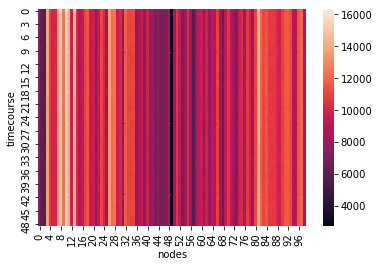

In [3]:
#read in the shen-parcellated timecourses for all subjects and all nodes (subj*timecourseperrun*node)
f_RL = h5py.File("shen268_timecourses_RL.hdf5", "r") 
f_LR = h5py.File("shen268_timecourses_LR.hdf5", "r")

#playing around with this datatype
type(f_RL)
print('f_RL.keys()=',f_RL.keys(), '\n') # h5py.File() acts like a dictionary

# Exploring the datatype
d = f_RL['shen268_timecourses'] 
print('type(d)=', type(d))# d is of type Dataset. Like NumPy arrays, datasets have both a shape and a data type.
print('d.shape=',d.shape) # subjects, scan volumes, nodes
print('d.dtype=',d.dtype)
print('d=',d, "\n")

d_RL = np.array(f_RL['shen268_timecourses']) # extracting timecourses and converting them to arrays
print('type(d_RL):',type(d_RL))
print('d_RL.shape',d_RL.shape)
#plt.matshow(d_RL[0,1:50,1:100]) # time vs. nodes
sns.heatmap(d_RL[0,1:50,1:100]) # plot a few timepts and nodes to get an idea
plt.xlabel("nodes")
plt.ylabel("timecourse")
print('d_RL.shape',d_RL.shape)

Looks like timecourses are more similar across time within a node than across nodes - make sense - it could reflect firing props of neurons within that node or anything else typical of an roi

Now let's get working on the dataset. First we need to extract the data per run

In [4]:
#extract fMRI data and subject names
dat = {}
dat["run1"] = np.array(f_RL['shen268_timecourses'])
dat["run2"] = np.array(f_LR['shen268_timecourses'])

subj_list = {}
subj_list["run1"] = [x.decode('utf8') for x in list(f_RL['subjlist'])] #RL --> order of subjects for run 1
subj_list["run2"] = [x.decode('utf8') for x in list(f_LR['subjlist'])] #LR

In [5]:
# info needed to make a block regressor
vid_onsets_in_sec = [8, 46, 84, 122, 160]
tr = 0.72
duration_secs = 20
l_task = int(np.round(duration_secs/tr))  # duration measured in nr of images = 28 for 20s
print('Duration of task block:', l_task)
print('Nr of fixation images:', np.round(15/tr))
l_fix = int(l_task/2)
print('setting baseline images at:',l_fix) # since there's fixation pre and post task block


Duration of task block: 28
Nr of fixation images: 21.0
setting baseline images at: 14


In [6]:
#exploring the timecourse
vid_onsets_imagenr = np.zeros_like(vid_onsets_in_sec)
for i in range(5):
    vid_onsets_imagenr[i] = np.floor((vid_onsets_in_sec[i]/tr)-1) # seconds to image nr (-1 since indices start from 0)
print(vid_onsets_imagenr)
print(np.diff(vid_onsets_imagenr)) # sanity check: are the distances between onset images the same?

[ 10  62 115 168 221]
[52 53 53 53]


# A la traditional-GLM analysis: BOLD timecourse = f(movie)


first analysis is simple - for each movie, node and subject, we create a block regressor including the movie time windows + fixations before and after it. Then we fit the equation: BOLD = b0+b1*stimPresence, and compare b1 across subjects responses etc. (stimPresence = 1 during the video block and 0 otherwise)

In [1]:
#defining the hrf
from nltools.external import glover_hrf

#hrf function
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

NameError: name 'tr' is not defined

In [ ]:
#create moviewise block regressors

reg_conv = []
nmovies = 10
yrows = [] # 10x1 list of rows
#plt.figure(figsize = (20,10))
for vid_no in range(nmovies):
    run = "run1" if vid_no < 5 else "run1"
    vrun = vid_no%5
    vid = vid_names[run][vrun]
    #print(vid)
    vidonset_imnr = np.floor((vid_onsets_in_sec[vrun]/tr)-1)
    if vrun == 0:
        start_frame = 0
    else:
        start_frame = int(vidonset_imnr) - l_fix # 14 frames of fix before task block
    #print('start_frame',start_frame)
    #if vrun == 4:
    #    end_frame = 274
    #else:
    end_frame = int(vidonset_imnr) + l_task + l_fix # 14 frames of fix after task block
    yrows_stim = np.arange(start_frame,end_frame)
    yrows.append(yrows_stim)
    vid_start = int(vidonset_imnr) # get the relevant frames by converting sec to tr
    vid_start = vid_start - start_frame
    #print('vid_start',vid_start)
    vid_end = vid_start + l_task
    #print('vid_end',vid_end)
    reg = np.zeros((end_frame-start_frame))
    reg[vid_start:vid_end] = 1
    #print(reg)
    #plt.subplot(5,2,vid_no+1)
    if vid_no == 0:
        plt.figure(figsize = (4,4))
        plt.plot(reg, label = 'block reg.', color = 'grey')
    reg1 = np.convolve(reg, hrf)
    #print('before:',len(reg), ', after',len(reg1))
    #reg1 = reg1[5:5+len(reg)]
    reg1 = reg1[:len(reg)]
    if vid_no == 0:
        plt.plot(reg1, label = 'reg. conv.')
        plt.legend(loc = 'lower left', fontsize = 16)
        plt.xlabel('Image #', fontsize = 16)
        plt.xticks(fontsize = 16)
        plt.yticks([0,1],['Fix.','Mov.'], fontsize = 16)
    reg_conv.append(reg1)


In [9]:
#extract behavioral data
beh_data = pd.read_csv("/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha/hcp_social_behav_for_ddm_stim-coding.csv")
rtmin = 0.1 # threshold for impossibly short RTs

print('nrows before removing short RTs=', beh_data.shape)
print("total subjects before=",len(np.unique(beh_data['subj_idx'])))
beh_data= beh_data[beh_data["rt"]>=rtmin]
print('\nnrows after removing short RTs=', beh_data.shape)
print("total subjects after=",len(np.unique(beh_data['subj_idx'])))
#print(np.where(beh_data.index == subj_shortRT[0]))

beh_data.head()

nrows before removing short RTs= (10149, 5)
total subjects before= 1051

nrows after removing short RTs= (9950, 5)
total subjects after= 1050


,subj_idx,stim,movie,rt,response
0,168745,Mental,Scaring.AVI,1.252,1
1,168745,Mental,SEDUCING-B.AVI,0.578,1
2,168745,Random,STAR-A.AVI,1.643,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1
4,168745,Random,TENNIS-A.AVI,1.232,0


In [10]:
# function needed for the GLM
from sklearn.linear_model import LinearRegression

In [11]:
os.chdir(r"/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/")

subj: 0 , time elapsed: 0.0005197525024414062
subj: 1 , time elapsed: 0.6184859275817871
subj: 2 , time elapsed: 1.2045929431915283
subj: 3 , time elapsed: 1.7671828269958496
subj: 4 , time elapsed: 2.2931058406829834
subj: 5 , time elapsed: 2.8180348873138428
subj: 6 , time elapsed: 3.35054087638855
subj: 7 , time elapsed: 3.881838083267212
subj: 8 , time elapsed: 4.414109945297241
subj: 9 , time elapsed: 4.9526519775390625
subj: 10 , time elapsed: 5.509679794311523
subj: 11 , time elapsed: 6.046252965927124
subj: 12 , time elapsed: 6.588671922683716
subj: 13 , time elapsed: 7.115072965621948
subj: 14 , time elapsed: 7.644798994064331
subj: 15 , time elapsed: 8.173916816711426
subj: 16 , time elapsed: 8.709823846817017
subj: 17 , time elapsed: 9.235971927642822
subj: 18 , time elapsed: 9.768633127212524
subj: 19 , time elapsed: 10.30135703086853
subj: 20 , time elapsed: 10.84481692314148
subj: 21 , time elapsed: 11.397095918655396
subj: 22 , time elapsed: 11.933260917663574
subj: 23 ,

subj: 188 , time elapsed: 101.52519178390503
subj: 189 , time elapsed: 102.0661849975586
subj: 190 , time elapsed: 102.60699272155762
subj: 191 , time elapsed: 103.14048194885254
subj: 192 , time elapsed: 103.68454504013062
subj: 193 , time elapsed: 104.21967792510986
subj: 194 , time elapsed: 104.76234698295593
subj: 195 , time elapsed: 105.30790090560913
subj: 196 , time elapsed: 105.84130573272705
subj: 197 , time elapsed: 106.38017988204956
subj: 198 , time elapsed: 106.93406987190247
subj: 199 , time elapsed: 107.49832701683044
subj: 200 , time elapsed: 108.06020784378052
subj: 201 , time elapsed: 108.6391248703003
subj: 202 , time elapsed: 109.18908905982971
subj: 203 , time elapsed: 109.76018786430359
subj: 204 , time elapsed: 110.32554078102112
subj: 205 , time elapsed: 110.88397002220154
subj: 206 , time elapsed: 111.45150780677795
subj: 207 , time elapsed: 112.00340676307678
subj: 208 , time elapsed: 112.57393789291382
subj: 209 , time elapsed: 113.13474583625793
subj: 210 , 

subj: 372 , time elapsed: 200.84124183654785
subj: 373 , time elapsed: 201.37639594078064
subj: 374 , time elapsed: 201.92523288726807
subj: 375 , time elapsed: 202.44821405410767
subj: 376 , time elapsed: 202.97709798812866
subj: 377 , time elapsed: 203.5161578655243
subj: 378 , time elapsed: 204.04239106178284
subj: 379 , time elapsed: 204.57503294944763
subj: 380 , time elapsed: 205.1229989528656
subj: 381 , time elapsed: 205.66156697273254
subj: 382 , time elapsed: 206.19418001174927
subj: 383 , time elapsed: 206.73878979682922
subj: 384 , time elapsed: 207.27278089523315
subj: 385 , time elapsed: 207.79578495025635
subj: 386 , time elapsed: 208.33996891975403
subj: 387 , time elapsed: 208.87143397331238
subj: 388 , time elapsed: 209.3963267803192
subj: 389 , time elapsed: 209.9208118915558
subj: 390 , time elapsed: 210.4573528766632
subj: 391 , time elapsed: 210.99510383605957
subj: 392 , time elapsed: 211.53912806510925
subj: 393 , time elapsed: 212.06770086288452
subj: 394 , tim

subj: 553 , time elapsed: 573.9330921173096
subj: 554 , time elapsed: 574.7760210037231
subj: 555 , time elapsed: 575.6302938461304
subj: 556 , time elapsed: 576.5019917488098
subj: 557 , time elapsed: 577.2939598560333
subj: 558 , time elapsed: 578.02965092659
subj: 559 , time elapsed: 579.1403677463531
subj: 560 , time elapsed: 579.9805088043213
subj: 561 , time elapsed: 580.6430740356445
subj: 562 , time elapsed: 581.2741320133209
subj: 563 , time elapsed: 581.8945858478546
subj: 564 , time elapsed: 582.4695007801056
subj: 565 , time elapsed: 583.1785268783569
subj: 566 , time elapsed: 583.8864488601685
subj: 567 , time elapsed: 584.4973847866058
subj: 568 , time elapsed: 585.1158668994904
subj: 569 , time elapsed: 585.8331010341644
subj: 570 , time elapsed: 586.417210817337
subj: 571 , time elapsed: 587.0031590461731
subj: 572 , time elapsed: 587.5396637916565
subj: 573 , time elapsed: 588.1457049846649
subj: 574 , time elapsed: 588.7317769527435
subj: 575 , time elapsed: 589.30649

subj: 737 , time elapsed: 681.3841698169708
subj: 738 , time elapsed: 681.9266078472137
subj: 739 , time elapsed: 682.4679889678955
subj: 740 , time elapsed: 682.9909608364105
subj: 741 , time elapsed: 683.5195429325104
subj: 742 , time elapsed: 684.0699648857117
subj: 743 , time elapsed: 684.6221370697021
subj: 744 , time elapsed: 685.1499488353729
subj: 745 , time elapsed: 685.676148891449
subj: 746 , time elapsed: 686.203400850296
subj: 747 , time elapsed: 686.748918056488
subj: 748 , time elapsed: 687.2872068881989
subj: 749 , time elapsed: 687.8288509845734
subj: 750 , time elapsed: 688.4537179470062
subj: 751 , time elapsed: 689.085175037384
subj: 752 , time elapsed: 689.714751958847
subj: 753 , time elapsed: 690.3188416957855
subj: 754 , time elapsed: 690.8775260448456
subj: 755 , time elapsed: 691.4237439632416
subj: 756 , time elapsed: 691.9629988670349
subj: 757 , time elapsed: 692.4977788925171
subj: 758 , time elapsed: 693.0462789535522
subj: 759 , time elapsed: 693.5940349

subj: 924 , time elapsed: 793.1459848880768
subj: 925 , time elapsed: 793.7506339550018
subj: 926 , time elapsed: 794.3300538063049
subj: 927 , time elapsed: 794.9107367992401
subj: 928 , time elapsed: 795.4882228374481
subj: 929 , time elapsed: 796.0622878074646
subj: 930 , time elapsed: 796.6537668704987
subj: 931 , time elapsed: 797.2314417362213
subj: 932 , time elapsed: 797.8198657035828
subj: 933 , time elapsed: 798.4049210548401
subj: 934 , time elapsed: 798.9886219501495
subj: 935 , time elapsed: 799.5766158103943
subj: 936 , time elapsed: 800.1641819477081
subj: 937 , time elapsed: 800.7400839328766
subj: 938 , time elapsed: 801.3232729434967
subj: 939 , time elapsed: 801.9186968803406
subj: 940 , time elapsed: 802.5022468566895
subj: 941 , time elapsed: 803.0783836841583
subj: 942 , time elapsed: 803.6631827354431
subj: 943 , time elapsed: 804.2436900138855
subj: 944 , time elapsed: 804.8351318836212
subj: 945 , time elapsed: 805.4142858982086
subj: 946 , time elapsed: 805.99

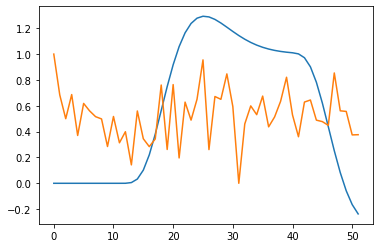

In [12]:
# Performing linear regression for each subject, movie and node. This takes about 10mins, so skip to the next cell to
# quickly load data stored previously


nsubj = 1053 # 1053
nmovies = 10
nnodes = 268
est_movie_block = np.zeros((nsubj,nmovies, nnodes))
start = time.time()

responses = np.zeros((nsubj,nmovies))-1
ind = -1 # to store the current subject nr
for s1 in np.arange(0,nsubj):
    now = time.time()
    print('subj:',s1,', time elapsed:', (now - start))
    curr_subj = subj_list['run1'][s1]
    try:
        s2 = subj_list['run2'].index(curr_subj) # see if the subject has data for run 2 as well
        curr_subj = int(curr_subj)
        ind += 1
        for vid_no in np.arange(0,nmovies):
            run = 'run1' if vid_no < 5 else 'run2'
            
            vidName = vid_names[run][vid_no%5]
            vidName = '.'.join((vidName,'AVI')) # add .avi
            row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
            if len(np.where(row)[0]) == 1: # number of rows with subj and movie should be 1
                responses[ind,vid_no] = beh_data.loc[row,'response']
            
            X = reg_conv[vid_no]
            for n in range(nnodes):
                if run == 'run1':
                    Y = dat[run][s1,yrows[vid_no],n] 
                elif run == 'run2':
                    Y = dat[run][s2,yrows[vid_no],n]
                Y = Y - np.min(Y)
                Y = Y/np.max(Y)
                #Y = Y - Y[0] # baseline correction
                if n== 0 and vid_no==0 and ind == 0:
                    plt.plot(X)
                    plt.plot(Y)
                X = X.reshape((-1, 1))
                model = LinearRegression().fit(X, Y) # normalised data
                est_movie_block[ind,vid_no,n] = model.coef_[0] #normalised data
                #if n== 0 and vid_no == 0 and ind == 0:
                #    print('reg coeff.:',model.coef_[0])
                #    print('reg coeff. norm:',model1.coef_[0])
    except:
            print(['only one subject for ind ',s1,', subjID:',curr_subj])

            print('total nr of subs:',ind+1)
est_movie_block = est_movie_block[:ind+1,:,:]
responses = responses[:ind+1,:]
print('Done.')
now = time.time()
print('total time:',now-start)
np.save('betapermovie_blockreg', est_movie_block)
np.save('responses_blockreg', responses)

In [13]:
pwd

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts'

In [14]:
# Load data instead of running the previous cell
est_movie_block = np.load('betapermovie_blockreg.npy')
responses = np.load('responses_blockreg.npy')

In [15]:
est_movie_block.shape # subs, movies, 168 Shen atlas nodes/ROIs

(1049, 10, 268)

<AxesSubplot:>

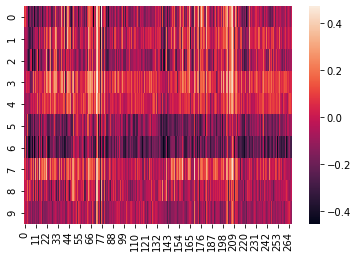

In [16]:
# Exploring results by plotting heatmaps for a subject (for each movie and node)
sns.heatmap(est_movie_block[0,:,:])

# Comparing yes vs. no

In this section, I compare the beta values between yes and no responders for each movie using an unpaired t-test

In [19]:
# Computing t-scores between yes and no responses for each movie and node
nnodes = 268
nmovies = 10
tResp_movie_block = np.zeros((nnodes,nmovies))
pResp_movie_block = np.zeros((nnodes,nmovies))
for n in range(nnodes):
    for m in np.arange(nmovies):
        allresp = responses[:,m]
        current_node = est_movie_block[:,m,n]

        if current_node.shape != allresp.shape:
            print('error!')
        
        resp_yes = allresp==1
        resp_no  = allresp==0
        if n+m==0:
            print(len(current_node[resp_yes]))
            print(len(current_node[resp_no]))
        t,p = stats.ttest_ind(current_node[resp_yes],current_node[resp_no])
        tResp_movie_block[n,m] = t
        pResp_movie_block[n,m] = p          

978
9


In [20]:
#bonf_threshold = .05/268 #bonferroni threshold

In [21]:
pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv("shen_dictionary.csv")
shen268.head()

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


In [ ]:
# functions to plot brain maps
#from nilearn.plotting import plot_glass_brain
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain        

In [228]:
# Plotting results and picking out maximum T-scores

def plot_figure_maxmin_movie(movie_ind, vid_joined,t,p, max_thr=.8, min_thr=.8, plotfig = 0):
    # function to plot significant nodes from a set of t-maps and pvals provided (one for each node) 
    # for movie subscripted as movie_ind (a value between 0 and 9)
    # max_thr and min_thr set the threshold as max_thr*maxvalue and min_thr*minvalue resp
    # vid_joined is a list of all 10 videos
    #movie_ind is the index of the movie we wish to plot
    # plotfig = plot (1) or don't plot (0) a thresholded T-map

    
    lbl = [str.upper(x[0:4]) for x in vid_joined]
    
    m = movie_ind # movienr
    mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
    mask_x = expand_mask(mask)
    t = t[:,m]
    p = p[:,m]
    psig =  np.zeros_like(p)
    psig[p <= 0.05] = 1
    if plotfig == 1:
        tsig = np.multiply(t,psig)
        tsig = np.array(tsig)
        img = roi_to_brain(pd.Series(tsig), mask_x)
        img.plot(colorbar=True, title = [lbl[m] + 'block'])
        
        #plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False)

    rois = np.where(t>=max_thr*np.max(t)) 
    rois = rois[0]
    roi_lbl = ["" for x in range(len(rois))]
    ind = -1
    for node_nr in rois:
        ind += 1
        roi_lbl[ind] = shen268[str(node_nr+1)][0]
    max_rois_list = pd.DataFrame({'ROIs': rois+1, 'T-scores': t[rois], 'p-values':p[rois], 'ROINames':roi_lbl})
    max_rois_list = max_rois_list.sort_values(by = ['T-scores'],ascending = False)
    max_rois_list = max_rois_list.reset_index()

    rois = np.where(t<=min_thr*np.min(t))
    rois = rois[0]
    roi_lbl = ["" for x in range(len(rois))]
    ind = -1
    for node_nr in rois:
        ind += 1
        roi_lbl[ind] = shen268[str(node_nr+1)][0]
    min_rois_list = pd.DataFrame({'ROIs': rois+1, 'T-scores': t[rois], 'p-values':p[rois], 'ROINames':roi_lbl})
    min_rois_list = min_rois_list.sort_values(by = ['T-scores'],ascending = True)
    min_rois_list = min_rois_list.reset_index()
    min_rois_list
    
    return max_rois_list, min_rois_list

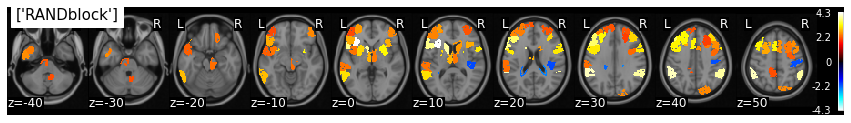

In [229]:
#Example use of function
movie_ind = 4
max_thr = .8
min_thr = .8
plotfig=1
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tResp_movie_block,pResp_movie_block,
                                                  max_thr,min_thr, plotfig)

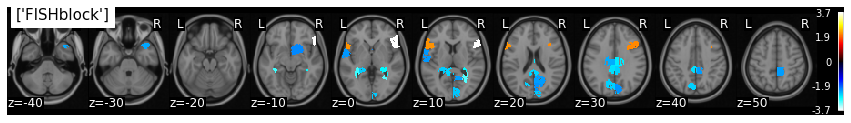

In [140]:
#Example use of function
movie_ind = 3
max_thr = .7
min_thr = .9
plotfig=1
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tResp_movie_block,pResp_movie_block,
                                                  max_thr,min_thr, plotfig)

In [ ]:
max_rois_list # nodes showing the highest T-scores

# Plotting timecourses for peak voxels

This part contains the code for timepoint by timepoint comparisons

In [107]:
def make_timecourse_movie(movie_ind, est_movie_block, nt):
    #Function to extract timecourses for a movie given movie_ind, number of timepoints (nt) to be plotted and n)
    #est_movie_block is the array of regressors - useful to draw out nr. of subs, nodes etc.

    nsubj = est_movie_block.shape[0] #1053
    nnodes = est_movie_block.shape[2]#268
    movie_tc = np.zeros((nsubj,nnodes,nt))
    #start = time.time()

    ind = -1
    for s1 in np.arange(0,nsubj):
        now = time.time()
        #print('subj:',s1,', time elapsed:', (now - start))
        curr_subj = subj_list['run1'][s1]
        try:
            s2 = subj_list['run2'].index(curr_subj) # see if the subject has data for run 2 as well
            curr_subj = int(curr_subj)
            ind += 1
            for vid_no in [movie_ind]:
                run = 'run1' if vid_no < 5 else 'run2'
                for n in range(nnodes):
                    if run == 'run1':
                        Y = dat[run][s1,yrows[vid_no],n] 
                    elif run == 'run2':
                        Y = dat[run][s2,yrows[vid_no],n]
                    Y = (Y - np.min(Y))
                    Y = Y/np.max(Y) # baseline correction and normalisation
                    if n== 0 and vid_no==0 and ind == 0:
                        plt.plot(Y)
                    movie_tc[ind,n,:] = Y

        except:
                print(['only one subject for ind ',s1,', subjID:',curr_subj])
    
    print('Done.')
    now = time.time()
    print('total time:',now-start)
    
    return movie_tc

In [108]:
# testing the above function
movie_ind = 4
nt = 56
movie_tc = make_timecourse_movie(movie_ind, est_movie_block, nt)

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Done.
total time: 2655.308402776718


In [194]:
def yes_vs_no_ttest(movie_tc, rois_list, responses, i):
    # This function performs an unpaired t-test between yes and no for each timepoint of the max or min 
    # (max_roi_list or min_roi_list) voxels plotted above.
    # i is the row number for the sorted max_rois_list dataframe.
    #Invoked within the function below
    
    allresp = []
    resp_yes = []
    resp_no = []
    allresp = responses[:,movie_ind]
    resp_yes = allresp==1
    resp_no  = allresp==0
    
    nt = movie_tc.shape[2]
    tscore = np.zeros((nt,))
    pval = np.zeros((nt,))-1
    
    if i < len(rois_list):
        node = rois_list.sort_values(by = ['T-scores'],ascending = False).iloc[i,:]['ROIs']
        print(node)
        node_ind = node - 1 # since indexing starts from 0
        for imno in range(nt): #time
            t,p = stats.ttest_ind(movie_tc[resp_yes,node_ind,imno],movie_tc[resp_no,node_ind,imno])
            tscore[imno] = t
            pval[imno] = p
    else:
        print('too few rois'+str(len(max_rois_list)))

    return tscore, pval

In [257]:
def plot_yes_vs_no_timecourse(movie_ind,responses, rois_list, movie_tc,ttype): 
    # plot yes vs no timecourses for the peak nodes and also yes-no
    # rois_list = can be max_roi_list or min_roi_list for movie movie_ind
    # movie_tc is the timecourse obtained from the make_timecourse_movie function
    #ttype = 'Resp' for Yes vs no or unsure comparisons (currently implementation only for Yes v No) or
    # 'Cert' for Sure vs Unsure comparisons
    
    if ttype == 'Resp':
        lbl1 = ['Yes','No', 'Unsure']
        lbl2 = 'Yes-No'
    elif ttype =='Cert':
        lbl1 = ['Sure','Unsure']
        lbl2 = 'Sure-Unsure'
        
    allresp = []
    resp_yes = []
    resp_no = []
    allresp = responses[:,movie_ind]
    resp_yes = allresp==1
    resp_no  = allresp==0
    resp_unsure  = allresp==9
    
    sp = 1
    num_nodes = len(max_rois_list)
    if num_nodes > 3:
        num_nodes = 3
        
    plt.figure(1,figsize = (12,6*num_nodes))
    
    for node in rois_list['ROIs'].iloc[:num_nodes]:
        node_ind = node-1 # node is between 1 and 268, movie_tc goes from 0 to 267
        #print(node_ind)
        plt.subplot(num_nodes*2,2,(sp-1)*2+1)
        plt.errorbar(x = range(nt),y = np.mean(movie_tc[resp_yes,node_ind,:], axis = 0), 
                     yerr = stats.sem(movie_tc[resp_yes,node_ind,:],axis = 0), label = lbl1[0])
        plt.errorbar(x = range(nt),y = np.mean(movie_tc[resp_no,node_ind,:], axis = 0), 
                     yerr = stats.sem(movie_tc[resp_no,node_ind,:],axis = 0), label = lbl1[1])
        #plt.errorbar(x = range(nt),y = np.mean(movie_tc[resp_unsure,node_ind,:], axis = 0), 
        #             yerr = stats.sem(movie_tc[resp_unsure,node_ind,:],axis = 0), label = ['unsure'])

        plt.legend(loc = 'lower right')
        plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
        tscore_node = rois_list.loc[rois_list['ROIs']==node,'T-scores']
        tscore_node = np.round(tscore_node.values[0],3)
        plt.title([str.upper(vid_joined[movie_ind][:4]),'Node ' + str(node),'T= ' + str(tscore_node)], fontsize = 16)
        plt.ylabel('Norm. BOLD \n activation', fontsize = 16)
        plt.xlabel('Image#', fontsize = 16)
        plt.ylim(0.25,0.8)

        tks = np.arange(0,nt,5)-np.where(reg)[0][0]
        tks = [str(i) for i in tks]
        plt.xticks(np.arange(0,nt,5),tks)
        
        tscore, pval = yes_vs_no_ttest(movie_tc, rois_list, responses,sp-1)
        print(pval)
        pthresh = np.where((pval<.05)&(pval>1e-20))[0]
        plt.vlines(pthresh, -.5,1.4, alpha = .2, label = 'p<.05unc.yesvno')

        plt.legend(loc = 'lower left')
        
        plt.subplot(num_nodes*2,2,sp*2)
        sp += 1 
        
        plt.plot(range(nt),np.mean(movie_tc[resp_yes,node_ind,:], axis = 0) 
             - np.mean(movie_tc[resp_no,node_ind,:], axis = 0), label = lbl2)
        plt.hlines(0,0,56,'k')
        plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
        plt.title([str.upper(vid_joined[movie_ind][:4]),'Node ' + str(node),'T= ' + str(tscore_node)], fontsize = 16)
        plt.ylabel('Mean BOLD diff', fontsize = 16)
        plt.xlabel('Image#', fontsize = 16)
        plt.ylim(-.2,0.2)
        plt.legend(loc = 'lower left')

    plt.tight_layout()

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Done.
total time: 8894.903836965561
155
[5.11703716e-02 7.14444214e-02 4.44371941e-03 9.11155150e-02
 6.17421496e-01 1.62234422e-01 7.44578789e-01 2.83521484e-01
 1.00188155e-02 5.62828945e-02 2.15547882e-03 1.16622592e-02
 2.10481394e-01 8.09525666e-02 1.68892575e-02 2.12497662e-01
 6.34020592e-03 6.67066504e-02 1.43131331e-01 8.11310416e-03
 4.34636450e-02 2.02608425e-01 2.20845376e-01 3.62638040e-01
 1.17131470e-01 8.41286845e-01 7.64662406e-01 6.49766942e-01
 5.05145559e-01 6.73800618e-01 7.90735417e-01 3.69797923e-01
 4.90630444e-01 7.45038723e-01 3.46503357e-01 2.09411761e-01
 1.29804900e-01 6.87327652e-02 2.58366713e-02 4.13433634e-04
 1.50746545e-04 1.20649316e-03 3.78975322e-03 8.28128505e-03
 4.48661756e-01 7.91686439e-01 7.08601172e-01 5.53287975e

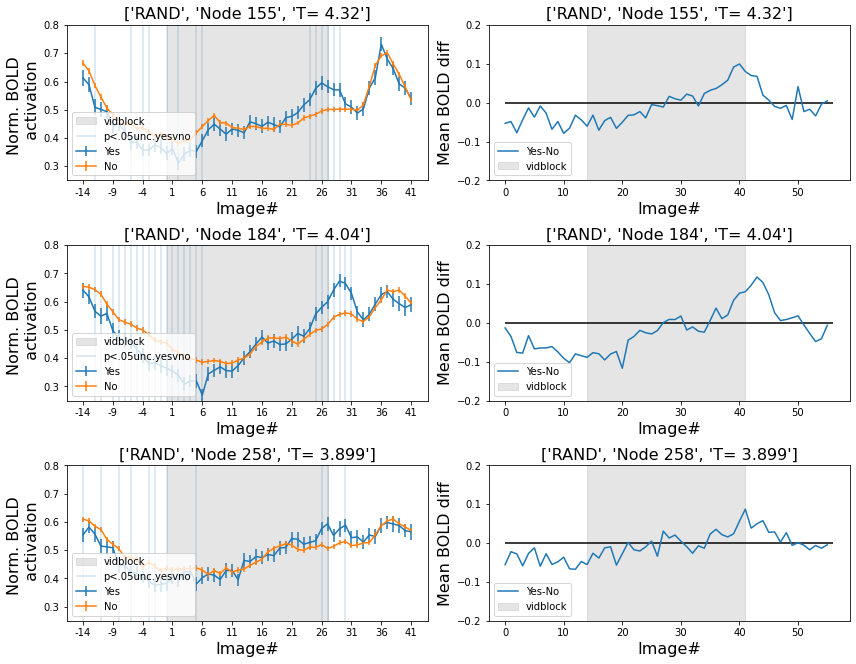

In [258]:
# testing the functions, plotting timecourses for RAND
movie_ind = 4
max_thr = .8
min_thr = .8
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tResp_movie_block,pResp_movie_block,
                                                  max_thr,min_thr,0)
movie_tc = make_timecourse_movie(movie_ind, est_movie_block, nt = 56,nnodes = 268)
plot_yes_vs_no_timecourse(movie_ind,responses, max_rois_list, movie_tc,'Resp')

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Done.
total time: 8923.831861019135
257
[0.45944208 0.15930191 0.49906207 0.8959164  0.6449431  0.05109521
 0.74667329 0.45668351 0.72618568 0.09090752 0.60876513 0.26394699
 0.29398978 0.33828129 0.3461651  0.14797871 0.3630002  0.81039682
 0.93874131 0.34144975 0.73009004 0.72302314 0.7530556  0.87861756
 0.23386993 0.52901164 0.1101459  0.14144718 0.04162825 0.67274332
 0.40315304 0.43398739 0.82129003 0.12375201 0.67423883 0.13183909
 0.38557903 0.07897135 0.00944558 0.67403459 0.03787403 0.01591748
 0.18456478 0.224138   0.48225919 0.65013455 0.06521728 0.19982882
 0.93924058 0.57355131 0.08176701 0.64624813 0.37936463 0.16228223
 0.49755529 0.3995082 ]
62
[0.68590739 0.76949892 0.33716534 0.50100906 0.68493067 0.20969328
 0.03777704 0.79637153 0.802202

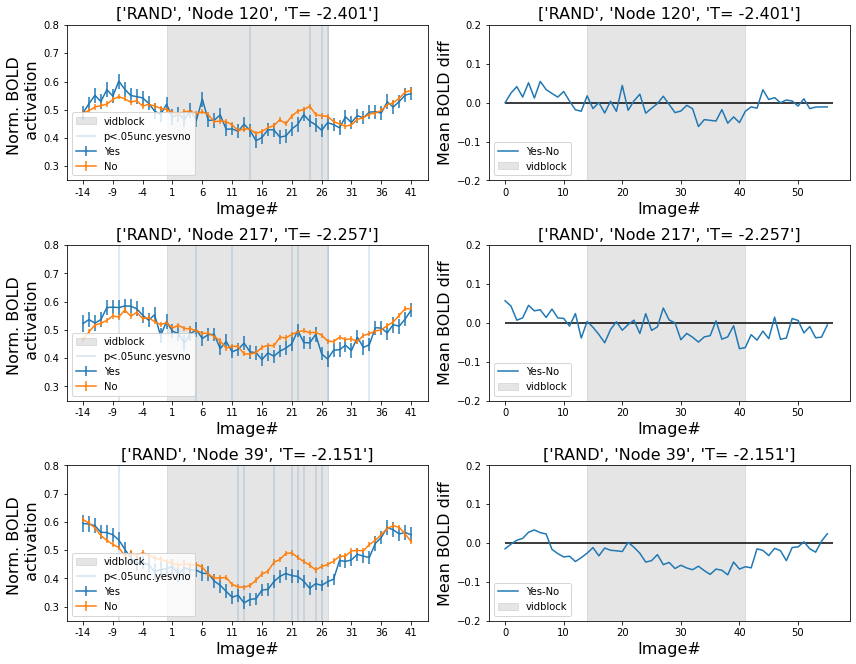

In [259]:
movie_ind = 4
max_thr = .8
min_thr = .8
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tResp_movie_block,pResp_movie_block,
                                                  max_thr,min_thr,0)
movie_tc = make_timecourse_movie(movie_ind, est_movie_block, nt = 56,nnodes = 268)
plot_yes_vs_no_timecourse(movie_ind,responses, min_rois_list, movie_tc,'Resp')

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Done.
total time: 8946.548311710358
16
[4.92096134e-01 1.48152665e-01 5.46145855e-03 1.31559934e-02
 9.68981080e-03 1.97603753e-02 2.58636105e-02 3.96217948e-03
 1.48262815e-02 5.16287209e-04 5.15518731e-03 9.07421180e-02
 2.02340008e-02 2.81675724e-01 3.53485956e-01 3.95953194e-02
 7.59562806e-01 1.25271700e-01 1.00112326e-01 2.30048299e-01
 1.91081724e-01 8.87628260e-01 8.55141570e-01 6.73755758e-01
 8.51366091e-01 9.97117791e-01 8.14907635e-01 2.65870457e-01
 1.34299732e-01 1.52813438e-01 9.90321507e-01 2.36208076e-01
 5.94078553e-02 1.31578398e-01 7.96379228e-01 7.93130800e-01
 1.01721512e-01 4.30106931e-01 8.14450687e-03 7.84529828e-02
 3.22008343e-01 9.99604676e-01 7.40825642e-01 1.15809321e-01
 1.02864129e-01 3.70804985e-01 6.02718582e-01 4.61989626e-

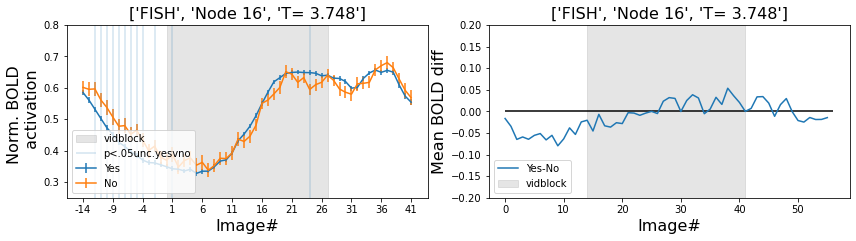

In [260]:
movie_ind = 3
max_thr = .8
min_thr = .8
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tResp_movie_block,pResp_movie_block,
                                                  max_thr,min_thr,0)
movie_tc = make_timecourse_movie(movie_ind, est_movie_block, nt = 56,nnodes = 268)
plot_yes_vs_no_timecourse(movie_ind,responses, max_rois_list, movie_tc,'Resp')

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Done.
total time: 8969.99311375618
229
[0.70131721 0.65402744 0.73990712 0.47629627 0.62790809 0.77369849
 0.69073211 0.33774335 0.89138425 0.0065827  0.95602429 0.51809945
 0.12164505 0.68754357 0.57984263 0.1489172  0.79822812 0.85783257
 0.06512736 0.77067823 0.15929793 0.53285493 0.7630112  0.99806776
 0.98296775 0.06252401 0.07617687 0.47161841 0.23267031 0.01119177
 0.03106645 0.04270264 0.13503053 0.08708284 0.689453   0.07819313
 0.61245883 0.51120817 0.15778813 0.93578959 0.57739754 0.16102747
 0.0265986  0.62383036 0.22901997 0.36080279 0.55355602 0.70218642
 0.25234599 0.60043533 0.4022702  0.2646446  0.03946158 0.64860853
 0.06731976 0.72327795]


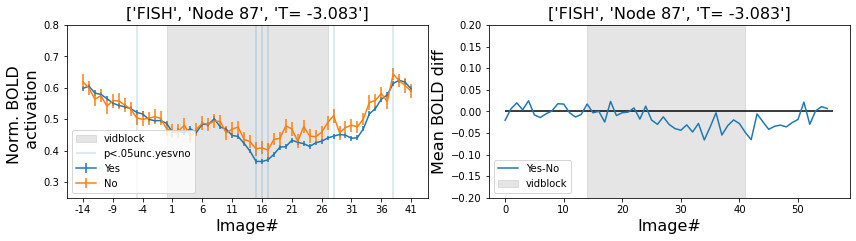

In [261]:
movie_ind = 3
max_thr = .8
min_thr = .8
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tResp_movie_block,pResp_movie_block,
                                                  max_thr,min_thr,0)
movie_tc = make_timecourse_movie(movie_ind, est_movie_block, nt = 56,nnodes = 268)
plot_yes_vs_no_timecourse(movie_ind,responses, min_rois_list, movie_tc,'Resp')

Differences aren't too impressive - could be partly because we don't get the best ROIs from a block model. Slope GLM might give us more meaningful nodes.

Let's see at what points the timepts emerge. Also to see if there's a baseline difference

There are also baseline differences for the voxels showing the highest (not lowest) differences between yes and no - could be a carryover effect from the previous trial.

In the lowest difference voxels for RAND (not FISHING), there's a >0 yes-no difference at baseline 

Hence for rand mech,
- if yes>no at baseline, during the block, this flips --> i.e. activity goes down for yes responders and up for no responders (and hence on average - since we obtain beta values per   block)
- if yes responders show less BOLD activity in a voxel than no at baseline, during the task, activity goes up for yes responders and down for no responders

# Comparing certain vs. uncertain responses' brain activity

In [262]:
# Computing t-scores between sure(yes+no) and unsure responses for each movie and node
nnodes = 268
nmovies = 10
tCert_movie_block = np.zeros((nnodes,nmovies))
pCert_movie_block = np.zeros((nnodes,nmovies))
for n in range(nnodes):
    for m in np.arange(nmovies):
        allresp = responses[:,m]
        current_node = est_movie_block[:,m,n]

        if current_node.shape != allresp.shape:
            print('error!')
        
        resp_sure = allresp!=9
        resp_unsure  = allresp==9
        if n+m==0:
            print(len(current_node[resp_sure]))
            print(len(current_node[resp_unsure]))
        t,p = stats.ttest_ind(current_node[resp_sure],current_node[resp_unsure])
        tCert_movie_block[n,m] = t
        pCert_movie_block[n,m] = p          

1040
9


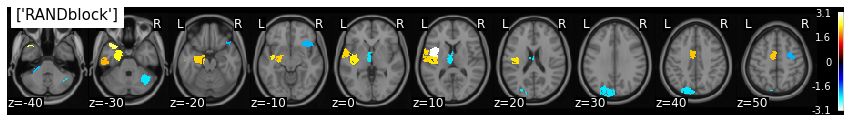

In [263]:
movie_ind = 4
max_thr = .8
min_thr = .8
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tCert_movie_block,pCert_movie_block,
                                                  max_thr,min_thr,1)

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Done.
total time: 9038.036390781403
168
[0.06527663 0.00783801 0.07389154 0.80064327 0.05807978 0.04452061
 0.63143394 0.8812896  0.1634082  0.8444327  0.29080913 0.95629698
 0.68503246 0.50635991 0.62079439 0.33790887 0.42609159 0.92734164
 0.28041225 0.47902421 0.28727937 0.71572326 0.41478199 0.68760553
 0.34653459 0.41480588 0.43233809 0.77640013 0.57750611 0.86357674
 0.69495262 0.79256953 0.22433308 0.99482033 0.74005173 0.95582925
 0.05685572 0.01825138 0.53304359 0.21008259 0.15307421 0.5180011
 0.58558862 0.15826083 0.85648461 0.43850396 0.58940319 0.93990758
 0.09255559 0.6389921  0.04121286 0.03183325 0.00609302 0.19119364
 0.14506108 0.00495232]
186
[0.30126644 0.67224787 0.91104816 0.21997543 0.74659136 0.7977259
 0.90489131 0.31381067 0.4344031

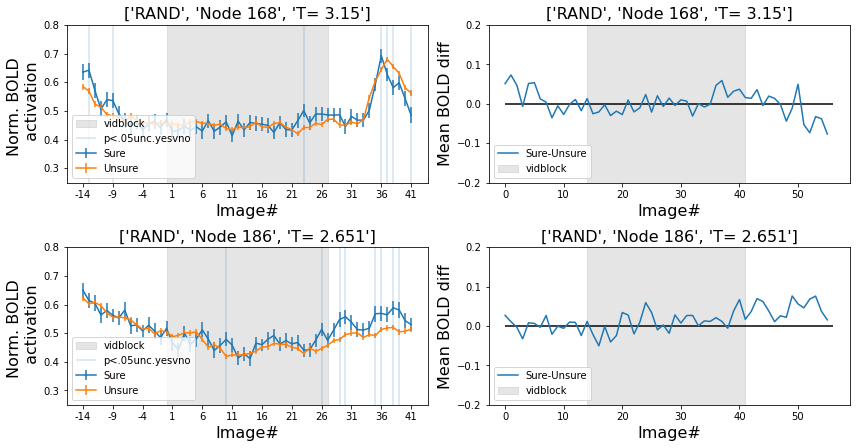

In [264]:
movie_ind = 4
max_thr = .8
min_thr = .8
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tCert_movie_block,pCert_movie_block,
                                                  max_thr,min_thr,0)
movie_tc = make_timecourse_movie(movie_ind, est_movie_block, nt = 56,nnodes = 268)
plot_yes_vs_no_timecourse(movie_ind,responses, max_rois_list, movie_tc,'Cert')

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Done.
total time: 9091.206926822662
215
[7.70166387e-01 7.23064408e-01 1.77537441e-01 3.04815755e-01
 5.68889498e-01 8.51439769e-01 5.93799675e-01 4.59614045e-01
 8.93780232e-01 9.95364338e-01 8.98304840e-01 2.56388809e-01
 4.52760931e-01 4.48549406e-01 8.70402771e-01 6.10884930e-01
 4.89024647e-01 7.37756379e-01 6.00113165e-01 7.96659790e-01
 7.57600517e-01 7.62878180e-01 3.62697002e-01 1.53356706e-01
 5.81663929e-01 5.29292542e-01 4.13766014e-01 2.36836411e-01
 9.96934149e-01 6.55184238e-01 2.91247232e-01 5.58246253e-01
 6.12046034e-01 4.07918122e-01 3.12942589e-01 9.81397392e-01
 9.15778299e-01 3.84980397e-01 7.49274929e-01 6.00346904e-01
 8.58032769e-03 1.72451688e-01 3.40186253e-01 9.64706652e-03
 3.79025692e-03 2.04243721e-02 2.46974534e-01 2.37126647e

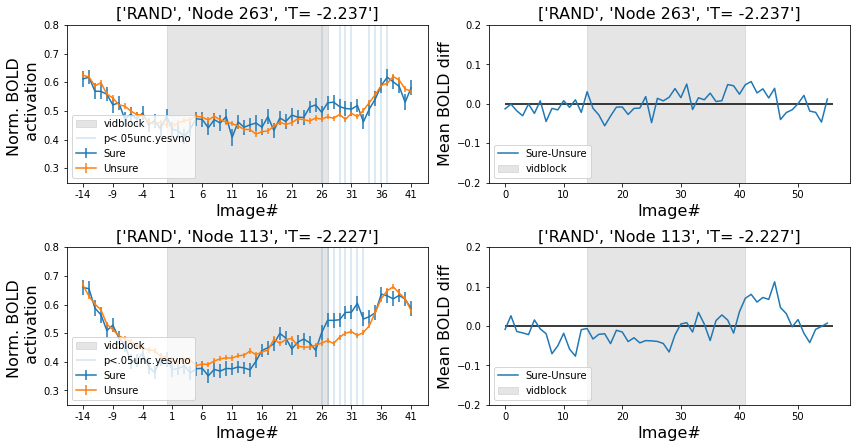

In [265]:
movie_ind = 4
max_thr = .8
min_thr = .8
max_rois_list, min_rois_list =  plot_figure_maxmin_movie(movie_ind, vid_joined,tCert_movie_block,pCert_movie_block,
                                                  max_thr,min_thr,0)
movie_tc = make_timecourse_movie(movie_ind, est_movie_block, nt = 56,nnodes = 268)
plot_yes_vs_no_timecourse(movie_ind,responses, min_rois_list, movie_tc,'Cert')

Below is unedited code used to explore some things.. Ideally, this is how far I have clean code for the block reg model
.
Conclusion so far: block regressor is probably not best, especially when response screen isn't included. We found some interesting ROIs but these are prob not the most discriminatory.

# UNFINISHED ANALYSES

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Decoding accuracy')

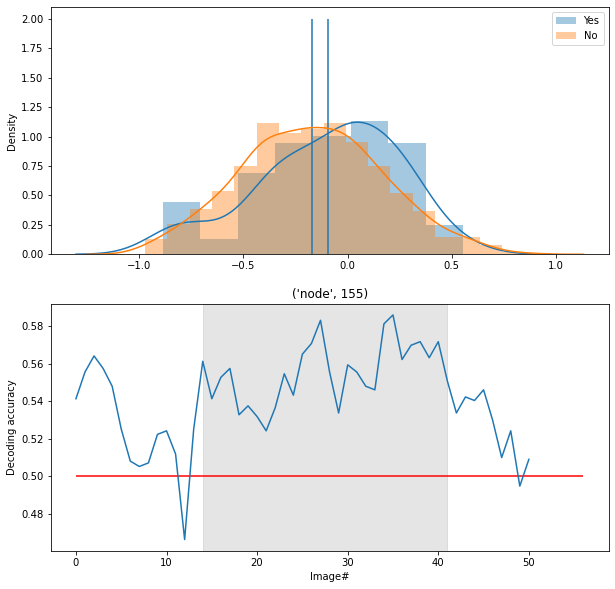

In [216]:
# TODO: EDIT THIS TO DO LEAVE-ONE-OUT: RIGHT NOW THE DATA USED TO CALCULATE MEAN IS USED TO ALSO PREDICT CATEGORY
import scipy as sp
DA = np.zeros((nt,))
for i in range(nt):
    tom_values = movie_tc[resp_yes,node,i]-movie_tc[resp_yes,node,0]
    tom_values = tom_values.squeeze()
    rnd_values = movie_tc[resp_no,node,i]-movie_tc[resp_no,node,0]
    rnd_values = rnd_values.squeeze()

    m_tom, s_tom = sp.stats.norm.fit(tom_values)
    m_rnd, s_rnd = sp.stats.norm.fit(rnd_values)

    movie_tc_bsln_corrected = movie_tc[:,node,i] - movie_tc[:,node,0]
    pred = [(abs(m_tom-x) < abs(m_rnd-x)) for x in movie_tc_bsln_corrected.squeeze()]
    DA[i] = (resp_yes==pred).sum()/len(resp_yes)
    #print((resp_yes==pred).sum()/len(resp_yes))

plt.figure(1,figsize =(10,10))
plt.subplot(211)
sns.distplot(tom_values, label='Yes')
sns.distplot(rnd_values, label='No')
plt.vlines([m_tom,m_rnd],0,2)
plt.gca().legend()

plt.subplot(212)
plt.plot(DA[5:])
plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
plt.title(('node',node))
plt.hlines(.5,0,nt, color = 'r')
plt.xlabel('Image#')
plt.ylabel('Decoding accuracy')

# plt.gca().axvline(c, color='gray', linestyle='--')

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Decoding accuracy')

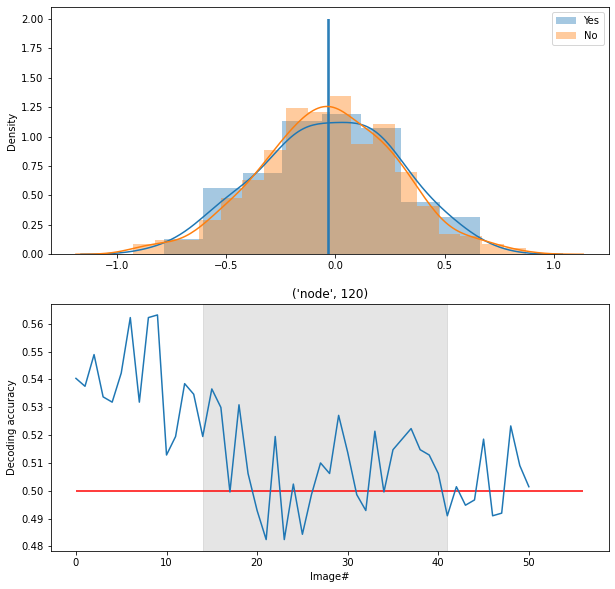

In [221]:
# TODO: EDIT THIS TO DO LEAVE-ONE-OUT: RIGHT NOW THE DATA USED TO CALCULATE MEAN IS USED TO ALSO PREDICT CATEGORY
node = min_rois_list.sort_values(by = ['T-scores'],ascending = True).iloc[0,:]['ROIs']
import scipy as sp
DA = np.zeros((nt,))
for i in range(nt):
    tom_values = movie_tc[resp_yes,node,i]-movie_tc[resp_yes,node,0]
    tom_values = tom_values.squeeze()
    rnd_values = movie_tc[resp_no,node,i]-movie_tc[resp_no,node,0]
    rnd_values = rnd_values.squeeze()

    m_tom, s_tom = sp.stats.norm.fit(tom_values)
    m_rnd, s_rnd = sp.stats.norm.fit(rnd_values)

    movie_tc_bsln_corrected = movie_tc[:,node,i] - movie_tc[:,node,0]
    pred = [(abs(m_tom-x) < abs(m_rnd-x)) for x in movie_tc_bsln_corrected.squeeze()]
    DA[i] = (resp_yes==pred).sum()/len(resp_yes)
    #print((resp_yes==pred).sum()/len(resp_yes))

plt.figure(1,figsize =(10,10))
plt.subplot(211)
sns.distplot(tom_values, label='Yes')
sns.distplot(rnd_values, label='No')
plt.vlines([m_tom,m_rnd],0,2)
plt.gca().legend()

plt.subplot(212)
plt.plot(DA[5:])
plt.hlines(.5,0,nt, color = 'r')
plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
plt.title(('node',node))
plt.xlabel('Image#')
plt.ylabel('Decoding accuracy')
# plt.gca().axvline(c, color='gray', linestyle='--')

In [222]:
len(np.where(resp_unsure==True)[0])

186

In [223]:
movie_tc.shape

(1053, 268, 56)

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

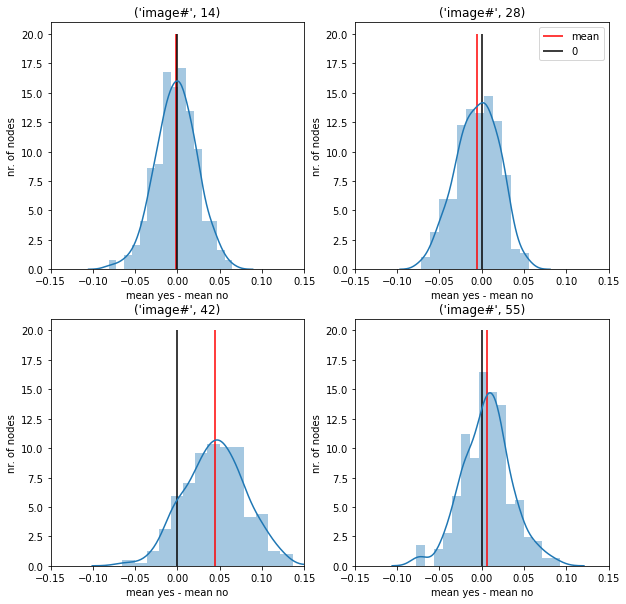

In [239]:
plt.figure(figsize =(10,10))
for i,t in enumerate([14,28,42,55]):
    plt.subplot(2,2,i+1)
    dt = np.mean(movie_tc[resp_yes,:,t],axis = 0)-np.mean(movie_tc[resp_no,:,t],axis=0)
    sns.distplot(dt)
    plt.vlines(np.mean(dt),0,20,'r', label = 'mean')
    plt.vlines(0,0,20,'k', label = '0')
    plt.xlabel('mean yes - mean no')
    plt.ylabel('nr. of nodes')
    plt.title(('image#',t))
    plt.xlim(-.15,.15)
    if i == 1:
        plt.legend()

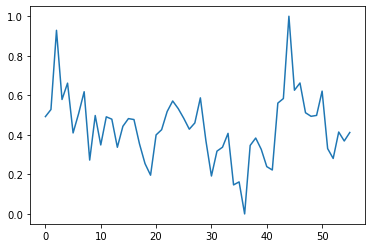

In [257]:
plt.plot(movie_tc[0,0,:])

In [275]:
def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window

    Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window

    There are smarter and faster solutions (e.g. using convolution) but this
    function shows what the output really means. This function skips NaNs, and
    should not be susceptible to edge effects: it will simply use
    all the  available samples, which means that close to the edges of the
    signal or close to NaNs, the output will just be based on fewer samples. By
    default, this function will apply a mean to the samples in the window, but
    this can be changed to be a max/min/median or other function that returns a
    single numeric value based on a sequence of values.
    """

    # if data is a matrix, apply filter to each row:
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],
                                             window=window,
                                             FUN=FUN)
        return output

    # make output array of the same size as x:
    output = np.zeros(x.size)

    # loop through the signal in x
    for samp_i in range(x.size):

        values = []

        # loop through the window:
        for wind_i in range(int(1 - window), 1):

            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue

            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]

        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)

    return output

In [456]:
Y

array([[0.10751863, 0.11746135, 0.26501879, ..., 0.32124397, 0.19901462,
        0.17814644],
       [0.36747594, 0.41783054, 0.43670483, ..., 0.26009948, 0.37310864,
        0.47830314],
       [0.30790992, 0.2966901 , 0.2979963 , ..., 0.23471367, 0.2138238 ,
        0.31184758],
       ...,
       [0.51056737, 0.35608242, 0.23778827, ..., 0.49683874, 0.31448227,
        0.35214761],
       [0.59991329, 0.41567534, 0.31669908, ..., 0.62322599, 0.5068817 ,
        0.31741748],
       [0.65072194, 0.48465843, 0.8073899 , ..., 0.22495353, 0.21936262,
        0.3299803 ]])

<ErrorbarContainer object of 3 artists>

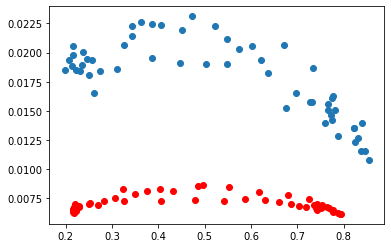

In [455]:
Y = movie_tc[resp_yes,73,:]
plt.errorbar(np.mean(Y,axis=0), stats.sem(Y, axis = 0),marker = 'o', ls = 'none')

Y = movie_tc[resp_no,73,:]
plt.errorbar(np.mean(Y,axis=0), stats.sem(Y, axis = 0),marker = 'o', color = 'r', ls = 'none')

In [411]:
len(np.where(resp_no==True)[0])

588

In [760]:
max_timept = np.zeros((268,2))
nsub_yes = len(np.where(resp_yes==True)[0])
nsub_no = len(np.where(resp_no==True)[0])
for node in range(268):
    maxt_yes = np.zeros((nsub_yes,))
    maxt_no  = np.zeros((nsub_no,))
    #print('node',node)
    yall_yes = movie_tc[resp_yes,node,:]
    for subj in range(nsub_yes):
        #print('subj',subj)
        Y = yall_yes[subj,:]
        Y = my_moving_window(Y)
        Y = Y[15:45]
        #print( np.where(Y==np.max(Y))[0])
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        maxt_yes[subj] = np.where(Y==np.max(Y))[0]
    
    yall_no = movie_tc[resp_no,node,:]
    for subj in range(nsub_no):   
        Y = yall_no[subj,:]
        Y = my_moving_window(Y)
        Y = Y[15:45]
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        maxt_no[subj] = np.where(Y==np.max(Y))[0]
    #max_timept[node] = np.mean(np.array(maxt_yes)) - np.mean(np.array(maxt_no))
    max_timept[node,0] = np.mean(np.array(maxt_yes))
    max_timept[node,1] = np.mean(np.array(maxt_no))

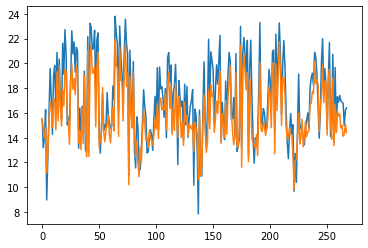

In [744]:
plt.plot(max_timept)


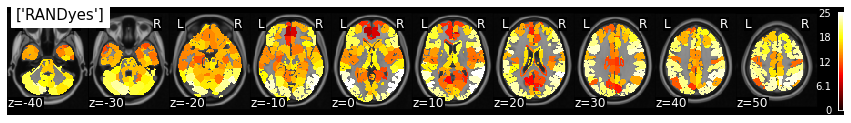

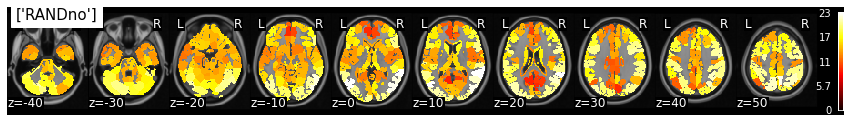

In [761]:
# check again, looks weird (V1 shows later activity..)
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
'''t = tResp_movie_block[:,m]
p = pResp_movie_block[:,m]
psig =  np.zeros_like(p)
psig[p <= 0.05] = 1
tsig = np.multiply(t,psig)
tsig = np.array(tsig)'''
img = roi_to_brain(pd.Series(max_timept[:,0]), mask_x)
img.plot(colorbar=True, title = [lbl[m] + 'yes'])
img = roi_to_brain(pd.Series(max_timept[:,1]), mask_x)
img.plot(colorbar=True, title = [lbl[m] + 'no'])

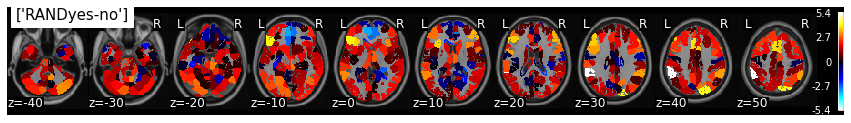

In [777]:
img = roi_to_brain(pd.Series(max_timept[:,0]-max_timept[:,1]), mask_x)
img.plot(colorbar=True, title = [lbl[m]+'yes-no'])

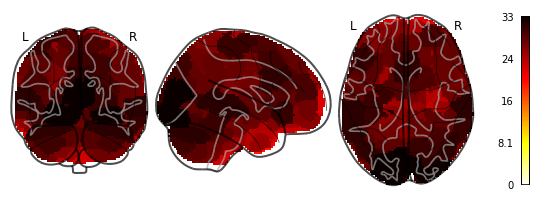

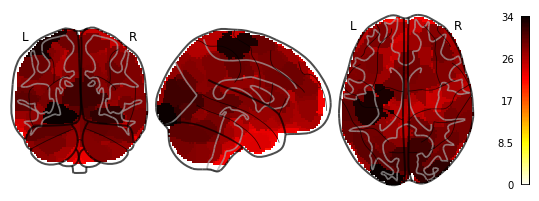

In [442]:
img = roi_to_brain(pd.Series(max_timept[:,0]), mask_x)
plot_glass_brain(img.to_nifti(), colorbar = True,plot_abs = False)
img = roi_to_brain(pd.Series(max_timept[:,1]), mask_x)
plot_glass_brain(img.to_nifti(), colorbar = True,plot_abs = False)

In [429]:
late_rois = np.where(max_timept>=.95*np.max(max_timept))[0]
early_rois = np.where(max_timept<=1.05*np.min(max_timept))[0]

In [395]:
#print(early_rois)
ind = -1
#roi_lbl = []
node_array = np.zeros(len(early_rois))
#print(node_array)
roi_lbl = ["" for x in range(len(early_rois))]
for node_nr in early_rois:
    ind += 1
    roi_lbl[ind] = shen268[str(node_nr)][0]
    node_array[ind] = np.round(node_nr)

#print(type(node_array))
#print(roi_lbl)
#print(max_timept[node_array.astype(int)])
early_rois_list = pd.DataFrame({'imagenr': max_timept[node_array.astype(int)],'node': node_array, 'ROIs': roi_lbl})

In [396]:
#print(early_rois)
ind = -1
#roi_lbl = []
node_array = np.zeros(len(late_rois))
#print(node_array)
roi_lbl = ["" for x in range(len(late_rois))]
for node_nr in late_rois:
    ind += 1
    roi_lbl[ind] = shen268[str(node_nr)][0]
    node_array[ind] = np.round(node_nr)

#print(type(node_array))
#print(roi_lbl)
#print(max_timept[node_array.astype(int)])
late_rois_list = pd.DataFrame({'imagenr': max_timept[node_array.astype(int)], 'node': node_array, 'ROIs': roi_lbl})

In [381]:
early_rois_list.sort_values(by = ['imagenr'],ascending = True)

,imagenr,node,ROIs
0,15.959164,137.0,"{'coords': [-7.816326530612244, 39.82312925170069, -21.4421768707483], 'name': '52.38% Frontal_Medial_Cortex; 27.72% Frontal_Pole; 12.59% Frontal_Orbital_Cortex; 7.31% Subcallosal_Cortex'}"


In [382]:
late_rois_list.sort_values(by = ['imagenr'],ascending = False)

,imagenr,node,ROIs
0,34.846154,213.0,"{'coords': [-14.564681724845997, -83.96714579055441, -12.991786447638603], 'name': '52.00% Occipital_Fusiform_Gyrus; 34.15% Lingual_Gyrus; 13.03% Occipital_Pole'}"


In [763]:
max_timept_cert = np.zeros((268,2))
nsub_sure = len(np.where(resp_sure==True)[0])
nsub_unsure = len(np.where(resp_unsure==True)[0])
for node in range(268):
    maxt_sure = np.zeros((nsub_sure,))
    maxt_unsure = np.zeros((nsub_unsure,))
    #print('node',node)
    yall_sure = movie_tc[resp_sure,node,:]
    for subj in range(nsub_sure):
        #print('subj',subj)
        Y = yall_sure[subj,:]
        Y = my_moving_window(Y)
        Y = Y[15:45]
        #print( np.where(Y==np.max(Y))[0])
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        #print(np.where(Y==np.max(Y))[0])
        maxt_sure[subj] = np.where(Y==np.max(Y))[0][0]
    
    yall_unsure = movie_tc[resp_unsure,node,:]
    for subj in range(nsub_unsure):  
        #print(subj)
        Y = yall_unsure[subj,:]
        #Y = my_moving_window(Y)
        Y = Y[15:45]
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        maxt_unsure[subj] = np.where(Y==np.max(Y))[0][0]
    #max_timept[node] = np.mean(np.array(maxt_yes)) - np.mean(np.array(maxt_no))
    max_timept_cert[node,0] = np.mean(np.array(maxt_sure))
    max_timept_cert[node,1] = np.mean(np.array(maxt_unsure))

In [764]:
np.where(max_timept_cert[:,0]== np.max(max_timept_cert[:,0]))[0]

array([208])

In [765]:
np.where(max_timept_cert[:,0]== np.min(max_timept_cert[:,0]))[0]

array([137])

In [766]:
np.where(max_timept_cert[:,1]== np.max(max_timept_cert[:,1]))[0]

array([64])

In [767]:
np.where(max_timept_cert[:,1]== np.min(max_timept_cert[:,1]))[0]

array([137])

In [768]:
np.where(max_timept[:,0]== np.max(max_timept[:,0]))[0]

array([64])

In [769]:
np.where(max_timept[:,0]== np.min(max_timept[:,0]))[0]

array([137])

In [770]:
np.where(max_timept[:,1]== np.max(max_timept[:,1]))[0]

array([64])

In [771]:
np.where(max_timept[:,1]== np.min(max_timept[:,1]))[0]

array([221])

In [752]:
shen268[str(64)][0]

"{'coords': [56.48476821192053, -8.543046357615893, -14.317880794701985], 'name': '44.52% Middle_Temporal_Gyrus_posterior_division; 21.40% Superior_Temporal_Gyrus_anterior_division; 19.42% Middle_Temporal_Gyrus_anterior_division; 7.93% Planum_Polare; 6.74% Superior_Temporal_Gyrus_posterior_division'}"

In [773]:
shen268[str(208)][0]

"{'coords': [-16.53098827470687, -84.96817420435511, 33.1105527638191], 'name': '54.10% Lateral_Occipital_Cortex_superior_division; 24.75% Occipital_Pole; 19.98% Cuneal_Cortex'}"

In [759]:
shen268[str(137)][0]

"{'coords': [-7.816326530612244, 39.82312925170069, -21.4421768707483], 'name': '52.38% Frontal_Medial_Cortex; 27.72% Frontal_Pole; 12.59% Frontal_Orbital_Cortex; 7.31% Subcallosal_Cortex'}"

In [774]:
shen268[str(221)][0]

"{'coords': [-4.9792531120331915, 13.273858921161832, 28.601659751037346], 'name': '84.44% Cingulate_Gyrus_anterior_division; 11.00% Left_Lateral_Ventrical'}"

In [780]:
node = 64



In [781]:
# performing unpaired ttests between yes and no responses at each timept
allresp = responses[:,movie_ind]
resp_yes = allresp==1
resp_no  = allresp==0

tscore = np.zeros((movie_tc.shape[2],))
pval = np.zeros((movie_tc.shape[2],))
for im in range(movie_tc.shape[2]):
    t,p = stats.ttest_ind(movie_tc[resp_yes,node,im],movie_tc[resp_no,node,im])
    tscore[im] = t
    pval[im] = p

([<matplotlib.axis.XTick at 0x7ffdee616640>,
 [Text(0, 0, '-14'),
  Text(5, 0, '-9'),
  Text(10, 0, '-4'),
  Text(15, 0, '1'),
  Text(20, 0, '6'),
  Text(25, 0, '11'),
  Text(30, 0, '16'),
  Text(35, 0, '21'),
  Text(40, 0, '26'),
  Text(45, 0, '31'),
  Text(50, 0, '36'),
  Text(55, 0, '41')])

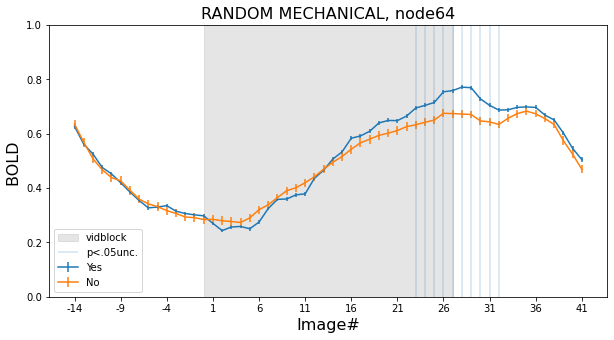

In [784]:
pthresh = np.where(pval<.05)[0]
plt.figure(figsize = (10,5))
#plt.plot(reg_conv[4] , label = 'regressor')
#plt.errorbar(x = range(72),y = np.mean(movie_tc[:,node,:], axis = 0), 
#             yerr = stats.sem(movie_tc[:,node,:],axis = 0), label ='all')
plt.errorbar(x = range(nt),y = np.mean(movie_tc[resp_yes,node,:], axis = 0), 
             yerr = stats.sem(movie_tc[resp_sure,node,:],axis = 0), label = 'Yes')
plt.errorbar(x = range(nt),y = np.mean(movie_tc[resp_no,node,:], axis = 0), 
             yerr = stats.sem(movie_tc[resp_unsure,node,:],axis = 0), label = 'No')
plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
plt.vlines(pthresh, -.5,1.4, alpha = .2, label = 'p<.05unc.')
plt.legend(loc = 'lower left')
plt.ylim(0,1)
plt.title((str.upper(vid_joined[movie_ind]) +', node' + str(node)), fontsize = 16)
plt.ylabel('BOLD ', fontsize = 16)
plt.xlabel('Image#', fontsize = 16)
tks = np.arange(0,nt,5)-np.where(reg)[0][0]
tks = [str(i) for i in tks]
plt.xticks(np.arange(0,nt,5),tks)



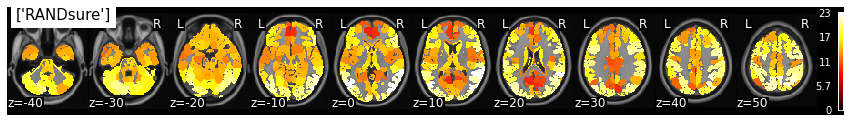

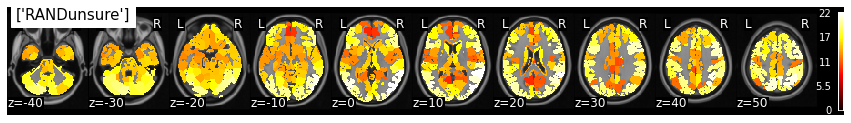

In [772]:
# check again, looks weird (V1 shows later activity..)
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
'''t = tResp_movie_block[:,m]
p = pResp_movie_block[:,m]
psig =  np.zeros_like(p)
psig[p <= 0.05] = 1
tsig = np.multiply(t,psig)
tsig = np.array(tsig)'''
img = roi_to_brain(pd.Series(max_timept_cert[:,0]), mask_x)
img.plot(colorbar=True, title = [lbl[m] + 'sure'])
img = roi_to_brain(pd.Series(max_timept_cert[:,1]), mask_x)
img.plot(colorbar=True, title = [lbl[m] + 'unsure'])

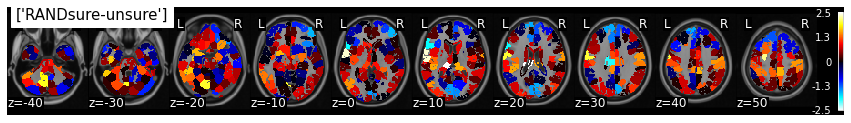

In [778]:
img = roi_to_brain(pd.Series(max_timept_cert[:,0]-max_timept_cert[:,1]), mask_x)
img.plot(colorbar=True, title = [lbl[m]+'sure-unsure'])

In [400]:
max_timept_bin = np.zeros((268,))
nsub = movie_tc.shape[0]
for node in range(268):
    maxt = np.zeros((nsub,))
    print('node',node)
    for subj in range(nsub):
        #print('subj',subj)
        Y = movie_tc[subj,node,:]
        Y = my_moving_window(Y)
        Y = Y[15:]
        ybin_mean = np.zeros((8,))
        for i in range(8):
            rows = np.arange(i*5,(i+1)*5)
            ybin = Y[rows]
            ybin_mean[i] = np.mean(ybin)
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        maxt[subj] = np.where(ybin_mean == np.max(ybin_mean))[0][0]
    max_timept_bin[node] = np.mean(np.array(maxt))

node 0
node 1
node 2
node 3
node 4
node 5
node 6
node 7
node 8
node 9
node 10
node 11
node 12
node 13
node 14
node 15
node 16
node 17
node 18
node 19
node 20
node 21
node 22
node 23
node 24
node 25
node 26
node 27
node 28
node 29
node 30
node 31
node 32
node 33
node 34
node 35
node 36
node 37
node 38
node 39
node 40
node 41
node 42
node 43
node 44
node 45
node 46
node 47
node 48
node 49
node 50
node 51
node 52
node 53
node 54
node 55
node 56
node 57
node 58
node 59
node 60
node 61
node 62
node 63
node 64
node 65
node 66
node 67
node 68
node 69
node 70
node 71
node 72
node 73
node 74
node 75
node 76
node 77
node 78
node 79
node 80
node 81
node 82
node 83
node 84
node 85
node 86
node 87
node 88
node 89
node 90
node 91
node 92
node 93
node 94
node 95
node 96
node 97
node 98
node 99
node 100
node 101
node 102
node 103
node 104
node 105
node 106
node 107
node 108
node 109
node 110
node 111
node 112
node 113
node 114
node 115
node 116
node 117
node 118
node 119
node 120
node 121
node 122
nod

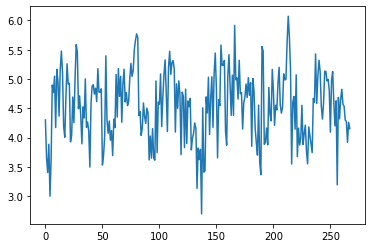

In [402]:
plt.plot(max_timept_bin)
#plt.axhspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading

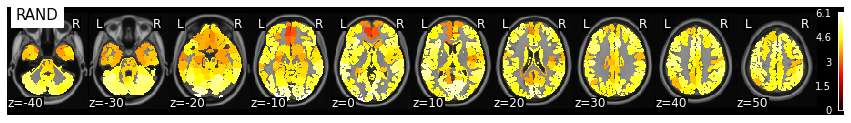

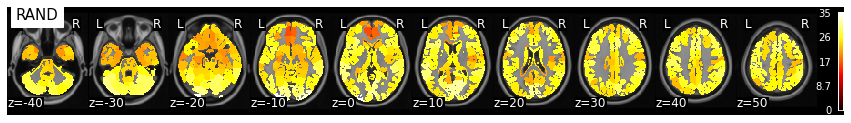

In [404]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
'''t = tResp_movie_block[:,m]
p = pResp_movie_block[:,m]
psig =  np.zeros_like(p)
psig[p <= 0.05] = 1
tsig = np.multiply(t,psig)
tsig = np.array(tsig)'''
img = roi_to_brain(pd.Series(max_timept_bin), mask_x)
img.plot(colorbar=True, title = lbl[m])

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
'''t = tResp_movie_block[:,m]
p = pResp_movie_block[:,m]
psig =  np.zeros_like(p)
psig[p <= 0.05] = 1
tsig = np.multiply(t,psig)
tsig = np.array(tsig)'''
img = roi_to_brain(pd.Series(max_timept), mask_x)
img.plot(colorbar=True, title = lbl[m])

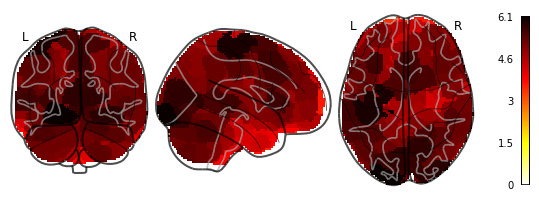

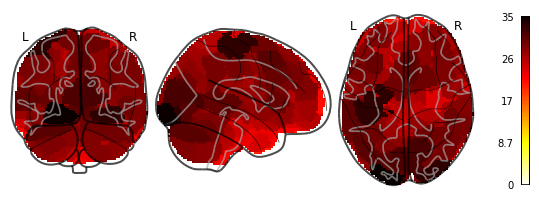

In [406]:
img = roi_to_brain(pd.Series(max_timept_bin), mask_x)
plot_glass_brain(img.to_nifti(), colorbar = True,plot_abs = True)
img = roi_to_brain(pd.Series(max_timept), mask_x)
plot_glass_brain(img.to_nifti(), colorbar = True,plot_abs = True)